# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

### Business Problem

### Objective

### Summary of Results

In [231]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [232]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [233]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [234]:
time0 = time.time()

with open('../input/lc-800k-sample/LCLoans_141_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc',                 
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd']

df = df[features_tokeep]


df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(200000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(200000, 61)

1.4242267608642578

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd
0,Charged Off,15000.0,15000.0,15000.0,36.0,5.32,451.730011,Jul-2015,debt_consolidation,Debt consolidation,w,Individual,A,A1,794.0,Director of Operations,9 years,OWN,125000.0,321xx,FL,12.890000,Not Verified,3.0,NaN,NaN,NaN,NaN,NaN,2.0,Jun-1989,0.0,NaN,NaN,10.0,4.0,4.0,20.0,31415.0,314152.0,14020.0,19.2,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,59092.0,0.0,0.0,0.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0
1,Current,34000.0,34000.0,34000.0,36.0,8.19,1068.420044,Nov-2019,debt_consolidation,Debt consolidation,w,Joint App,A,A4,714.0,Senior Job Captain,9 years,RENT,73000.0,908xx,CA,40.490002,Source Verified,3.0,12.0,NaN,NaN,48.0,48.0,2.0,Sep-2001,0.0,0.0,0.0,19.0,8.0,0.0,35.0,4220.0,80173.0,26630.0,45.7,1.0,0.0,0.0,0.0,0.0,131000.0,23.42,Source Verified,80173.0,1256.0,0.0,22.200001,94.300003,2.0,0.0,0.0,0.0,0.0,0.0
2,Current,40000.0,40000.0,40000.0,36.0,8.08,1254.939941,Jun-2018,credit_card,Credit card refinancing,w,Individual,A,A5,684.0,Executive Director,10+ years,MORTGAGE,300000.0,334xx,FL,11.460000,Source Verified,3.0,NaN,NaN,NaN,NaN,NaN,5.0,Nov-1983,1.0,1.0,2.0,23.0,6.0,4.0,42.0,46754.0,1075333.0,53053.0,53.1,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,426524.0,0.0,0.0,33.299999,100.000000,1.0,2.0,0.0,0.0,0.0,0.0
3,Current,12500.0,12500.0,12500.0,36.0,7.97,391.540009,Sep-2017,debt_consolidation,Debt consolidation,f,Individual,A,A5,709.0,Business Analyst,2 years,RENT,80000.0,402xx,KY,7.540000,Not Verified,5.0,NaN,NaN,NaN,NaN,NaN,4.0,Sep-2013,0.0,0.0,1.0,8.0,8.0,0.0,9.0,2680.0,21442.0,13341.0,27.7,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,21442.0,0.0,0.0,20.000000,100.000000,3.0,1.0,0.0,0.0,0.0,0.0
4,Current,24000.0,24000.0,24000.0,36.0,9.44,768.119995,Dec-2017,debt_consolidation,Debt consolidation,w,Individual,B,B1,714.0,warehouse,10+ years,MORTGAGE,65000.0,027xx,MA,16.190001,Source Verified,6.0,NaN,NaN,NaN,NaN,NaN,2.0,Oct-1996,0.0,0.0,1.0,16.0,4.0,3.0,32.0,9167.0,146673.0,15467.0,38.5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,28188.0,0.0,0.0,18.200001,100.000000,1.0,0.0,0.0,0.0,0.0,0.0


In [235]:
### feature description:

f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])


73    The number of open credit lines in the borrowe...
Name: desc, dtype: object

99    The total number of credit lines currently in ...
Name: desc, dtype: object

In [236]:
# clean time features

df.issue_d = df.issue_d.astype('O')
df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,Charged Off,15000.0,15000.0,15000.0,36.0,5.32,451.730011,2015-07-01,debt_consolidation,Debt consolidation,w,Individual,A,A1,794.0,Director of Operations,9 years,OWN,125000.0,321xx,FL,12.890000,Not Verified,3.0,NaN,NaN,NaN,NaN,NaN,2.0,1989-06-01,0.0,NaN,NaN,10.0,4.0,4.0,20.0,31415.0,314152.0,14020.0,19.2,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,59092.0,0.0,0.0,0.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2015.0,7.0,2015.0,26.081302,0.0
1,Current,34000.0,34000.0,34000.0,36.0,8.19,1068.420044,2019-11-01,debt_consolidation,Debt consolidation,w,Joint App,A,A4,714.0,Senior Job Captain,9 years,RENT,73000.0,908xx,CA,40.490002,Source Verified,3.0,12.0,NaN,NaN,48.0,48.0,2.0,2001-09-01,0.0,0.0,0.0,19.0,8.0,0.0,35.0,4220.0,80173.0,26630.0,45.7,1.0,0.0,0.0,0.0,0.0,131000.0,23.42,Source Verified,80173.0,1256.0,0.0,22.200001,94.300003,2.0,0.0,0.0,0.0,0.0,0.0,2019.0,11.0,2019.0,18.166013,0.0
2,Current,40000.0,40000.0,40000.0,36.0,8.08,1254.939941,2018-06-01,credit_card,Credit card refinancing,w,Individual,A,A5,684.0,Executive Director,10+ years,MORTGAGE,300000.0,334xx,FL,11.460000,Source Verified,3.0,NaN,NaN,NaN,NaN,NaN,5.0,1983-11-01,1.0,1.0,2.0,23.0,6.0,4.0,42.0,46754.0,1075333.0,53053.0,53.1,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,426524.0,0.0,0.0,33.299999,100.000000,1.0,2.0,0.0,0.0,0.0,0.0,2018.0,6.0,2018.0,34.582503,0.0
3,Current,12500.0,12500.0,12500.0,36.0,7.97,391.540009,2017-09-01,debt_consolidation,Debt consolidation,f,Individual,A,A5,709.0,Business Analyst,2 years,RENT,80000.0,402xx,KY,7.540000,Not Verified,5.0,NaN,NaN,NaN,NaN,NaN,4.0,2013-09-01,0.0,0.0,1.0,8.0,8.0,0.0,9.0,2680.0,21442.0,13341.0,27.7,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,21442.0,0.0,0.0,20.000000,100.000000,3.0,1.0,0.0,0.0,0.0,0.0,2017.0,9.0,2017.0,4.000082,0.0
4,Current,24000.0,24000.0,24000.0,36.0,9.44,768.119995,2017-12-01,debt_consolidation,Debt consolidation,w,Individual,B,B1,714.0,warehouse,10+ years,MORTGAGE,65000.0,027xx,MA,16.190001,Source Verified,6.0,NaN,NaN,NaN,NaN,NaN,2.0,1996-10-01,0.0,0.0,1.0,16.0,4.0,3.0,32.0,9167.0,146673.0,15467.0,38.5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,28188.0,0.0,0.0,18.200001,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2017.0,12.0,2017.0,21.166759,0.0


In [237]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             102070
Current                                                 70508
Charged Off                                             25072
Late (31-120 days)                                       1066
In Grace Period                                           708
Late (16-30 days)                                         204
Issued                                                    154
Does not meet the credit policy. Status:Fully Paid        136
Does not meet the credit policy. Status:Charged Off        47
Default                                                    34
Name: loan_status, dtype: int64

(127176, 67)

Fully Paid                                             102070
Charged Off                                             25072
Default                                                    34
Current                                                     0
Does not meet the credit policy. Status:Charged Off         0
Does not meet the credit policy. Status:Fully Paid          0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Late (31-120 days)                                          0
Name: loan_status, dtype: int64

loan_status                       127176
loan_amnt                         127176
funded_amnt                       127176
funded_amnt_inv                   127176
term                              127176
int_rate                          127176
installment                       127176
issue_d                           127176
purpose                           127176
title                             125723
initial_list_status               127176
application_type                  127176
grade                             127176
sub_grade                         127176
fico_range_high                   127176
emp_title                         118151
emp_length                        119162
home_ownership                    127176
annual_inc                        127176
zip_code                          127176
addr_state                        127176
dti                               127112
verification_status               127176
mo_sin_rcnt_tl                    122576
mths_since_last_

53.522552490234375

### Feature Preprocessing

In [238]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
dfloc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    41467
2.0     11578
0.0     10720
3.0     10224
1.0      8405
5.0      7891
4.0      7702
6.0      5800
7.0      5465
8.0      5281
9.0      4629
Name: emp_length, dtype: int64

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt
0,15000.0,15000.0,15000.0,36.0,5.32,451.730011,debt_consolidation,Debt consolidation,w,Individual,A,A1,794.0,Director of Operations,9.0,OWN,125000.0,321,FL,12.890000,Not Verified,3.0,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,10.0,4.0,4.0,20.0,31415.0,314152.0,14020.0,19.2,0.0,0.0,0.0,0.0,0.0,59092.0,0.0,0.0,0.000000,100.0,NaN,NaN,0.0,0.0,0.0,0.0,2015.0,7.0,2015.0,26.081302,0.0000,1.0,0.120000,0.043366,0,0.112160,0.251320,2.513216,0.472736,0,0.500000,0,0
6,8000.0,8000.0,8000.0,36.0,7.49,248.820007,credit_card,Credit card refinancing,f,Individual,A,A4,794.0,Medical Laboratory Technician,8.0,RENT,40000.0,532,WI,15.810000,Source Verified,17.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.0,11.0,2.0,0.0,21.0,1221.0,13430.0,5193.0,12.6,0.0,0.0,0.0,0.0,0.0,13430.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,3.0,2017.0,18.582175,0.0000,0.0,0.200000,0.074646,0,0.129825,0.030525,0.335750,0.335750,0,0.523810,0,0
8,27650.0,27650.0,27600.0,60.0,18.25,705.900024,credit_card,Credit card refinancing,f,Individual,D,D3,664.0,Service Manager,7.0,MORTGAGE,64000.0,402,KY,21.900000,Not Verified,7.0,NaN,NaN,110.0,NaN,NaN,2.0,1.0,NaN,NaN,20.0,7.0,4.0,38.0,8572.0,171430.0,19108.0,35.2,0.0,0.0,0.0,1.0,1.0,39776.0,0.0,0.0,71.400002,100.0,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,4.0,2014.0,18.248150,0.0548,1.0,0.432031,0.132356,0,0.298562,0.133937,2.678594,0.621500,0,0.526316,0,1
9,26400.0,26400.0,26300.0,36.0,8.39,832.039978,debt_consolidation,Debt consolidation,f,Individual,A,A5,709.0,Sr. Captain,10.0,OWN,220000.0,770,TX,18.370001,Source Verified,4.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,NaN,NaN,26.0,12.0,4.0,63.0,19411.0,427039.0,27020.0,48.1,0.0,0.0,0.0,0.0,0.0,113070.0,0.0,0.0,16.700001,100.0,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,6.0,2014.0,22.250970,0.0000,0.0,0.120000,0.045384,0,0.122818,0.088232,1.941086,0.513955,0,0.412698,0,0
11,6300.0,6300.0,6300.0,36.0,23.99,247.139999,debt_consolidation,Debt consolidation,f,Individual,E,E2,704.0,NaN,NaN,RENT,21000.0,104,NY,30.230000,Verified,9.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,4.0,3.0,0.0,5.0,3401.0,13604.0,6548.0,47.0,0.0,0.0,0.0,0.0,0.0,13604.0,0.0,0.0,0.000000,100.0,0.0,1.0,0.0,0.0,NaN,0.0,2016.0,10.0,2016.0,3.167758,0.0000,1.0,0.300000,0.141223,0,0.311810,0.161952,0.647810,0.647810,0,0.800000,0,0


In [239]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



loan_amnt                         127176
funded_amnt                       127176
funded_amnt_inv                   127176
term                              127176
int_rate                          127176
installment                       127176
purpose                           127176
title                             125723
initial_list_status               127176
application_type                  127176
grade                             127176
sub_grade                         127176
fico_range_high                   127176
emp_title                         118151
emp_length                        119162
home_ownership                    127176
annual_inc                        127176
zip_code                          127176
addr_state                        127176
dti                               127112
verification_status               127176
mo_sin_rcnt_tl                    127176
mths_since_last_delinq            127176
mths_since_last_major_derog       127176
mths_since_last_

In [240]:
df.mo_sin_rcnt_tl.describe()

count    127176.000000
mean         12.047650
std          22.650162
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         187.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [241]:
df.verification_status.value_counts()

Source Verified    50462
Not Verified       40231
Verified           36483
Name: verification_status, dtype: int64

In [242]:
df.target.mean()

0.1974114612820029

In [243]:
cat_features_te = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [244]:
df.application_type.value_counts()

Individual    122372
Joint App       4804
Name: application_type, dtype: int64

### EDA

In [245]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,127176.000000,127176.000000,127176.000000
mean,14587.708984,14581.026367,14563.877930
std,8982.503906,8980.163086,8981.475586
min,500.000000,500.000000,0.000000
25%,7800.000000,7800.000000,7800.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    95094
60.0    32082
Name: term, dtype: int64

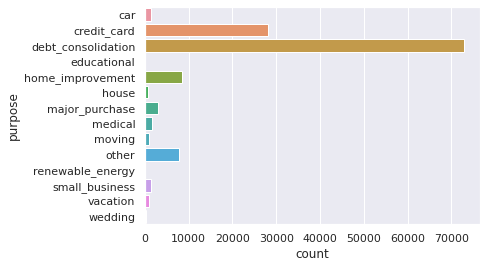

<AxesSubplot:xlabel='count', ylabel='emp_length'>

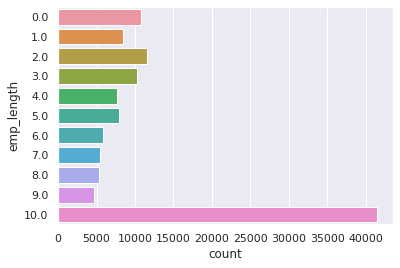

In [246]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [247]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [248]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    25106.000000
mean         0.342269
std          0.923091
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         25.000000
Name: delinq_2yrs, dtype: float64

count    102070.000000
mean          0.305163
std           0.860379
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: delinq_2yrs, dtype: float64

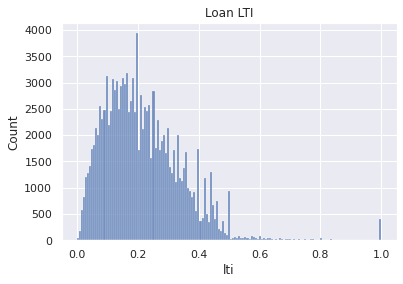

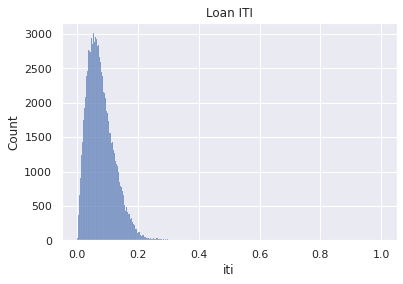

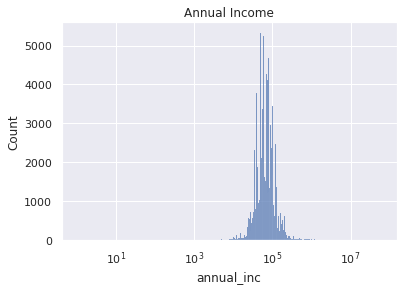

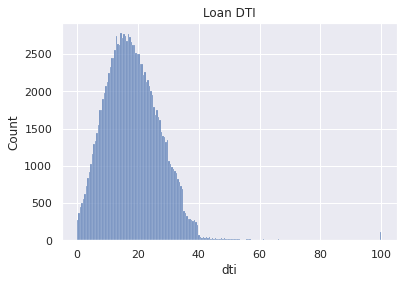

In [249]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [250]:
df.dti.describe()

count    127112.000000
mean         18.464220
std           9.380162
min           0.000000
25%          11.860000
50%          17.690001
75%          24.280001
max         100.000000
Name: dti, dtype: float64

[Text(0.5, 1.0, 'Loan Grade')]

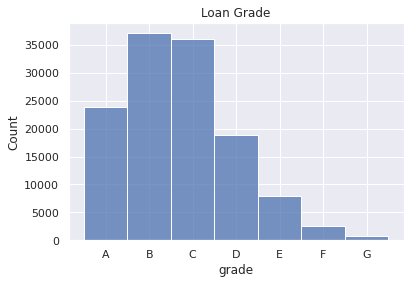

In [183]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

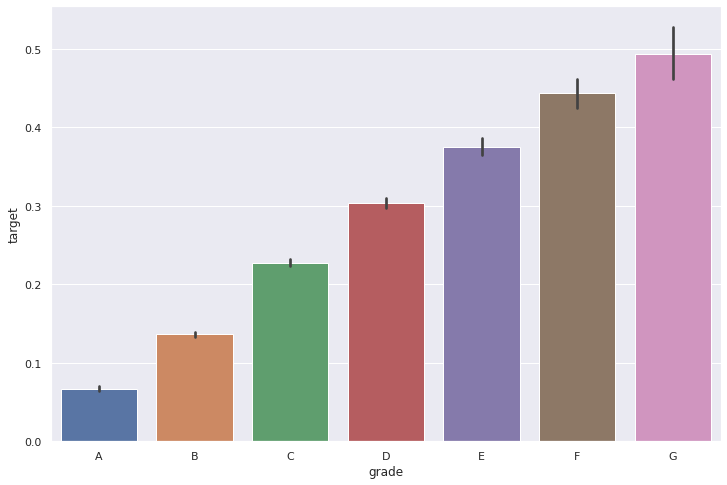

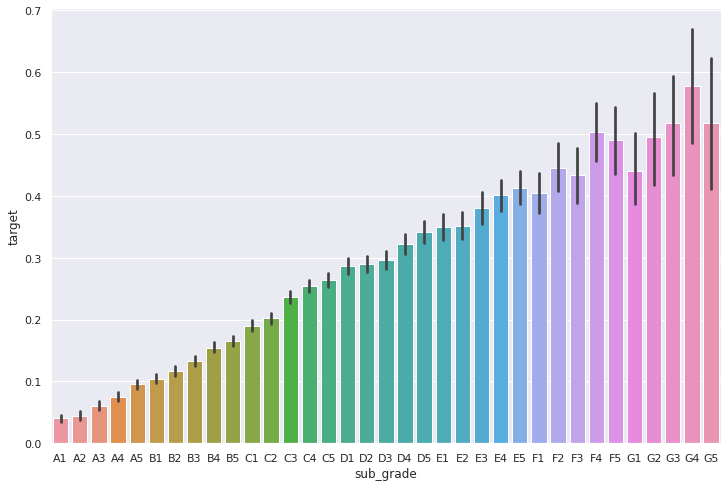

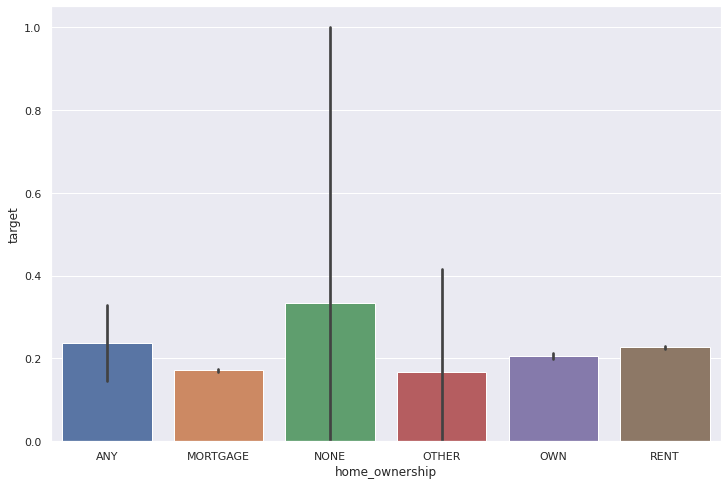

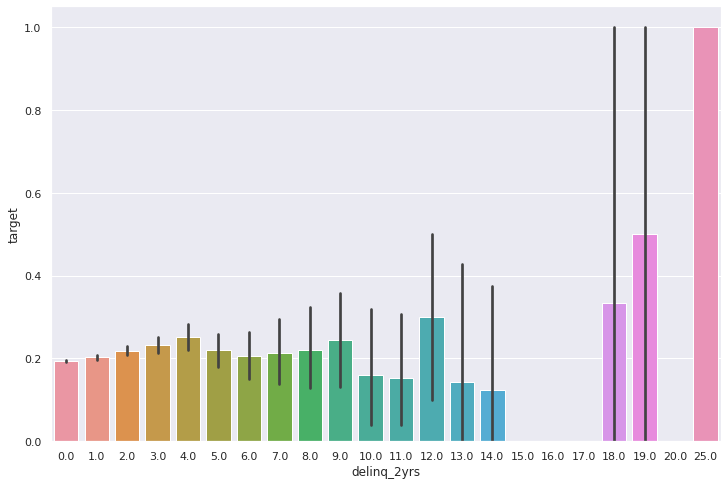

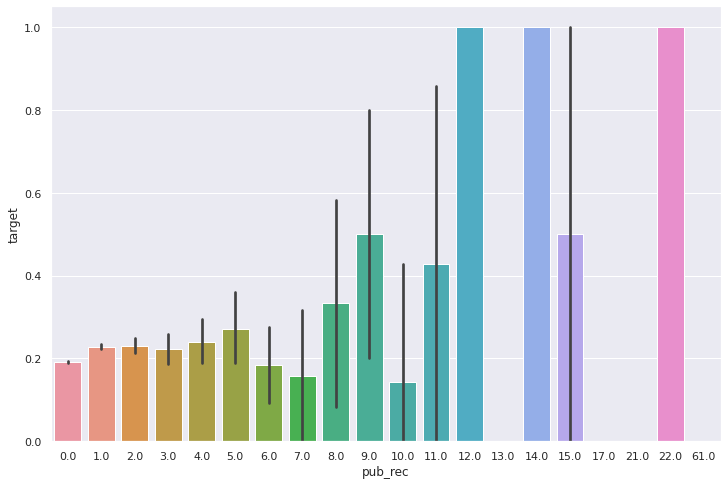

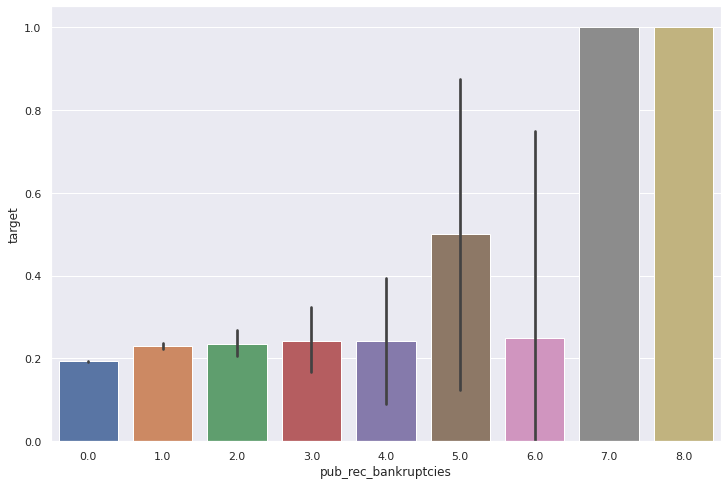

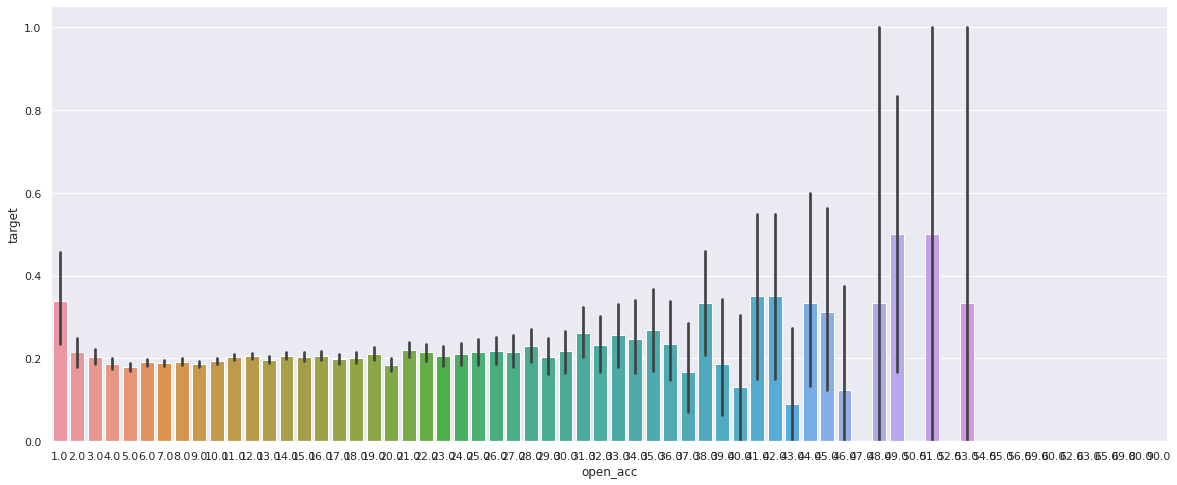

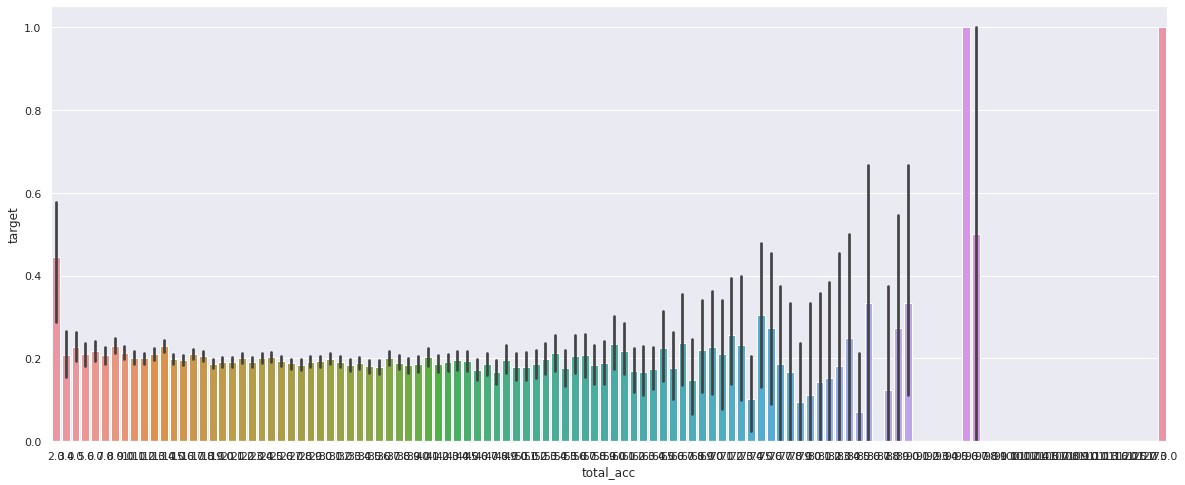

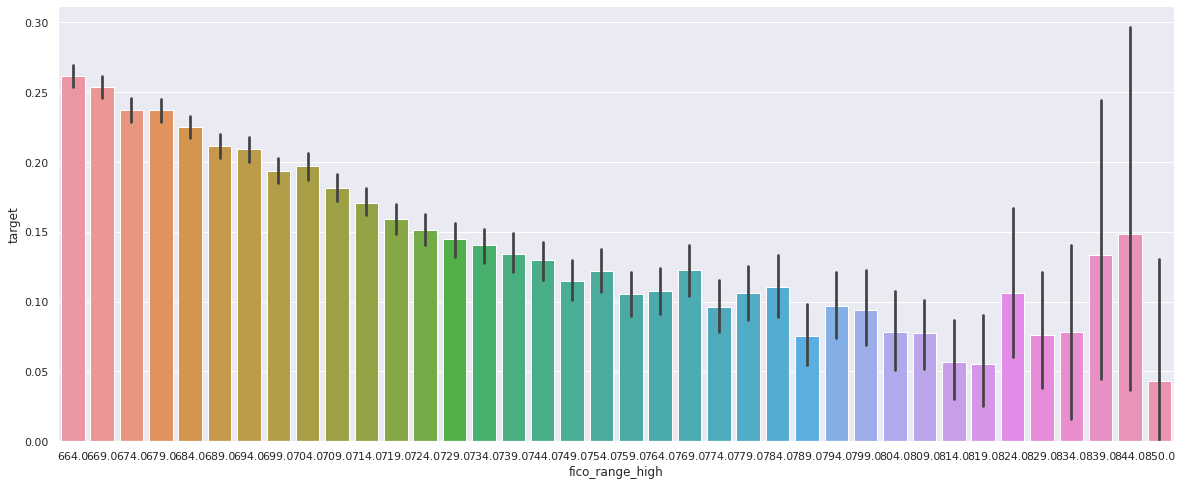

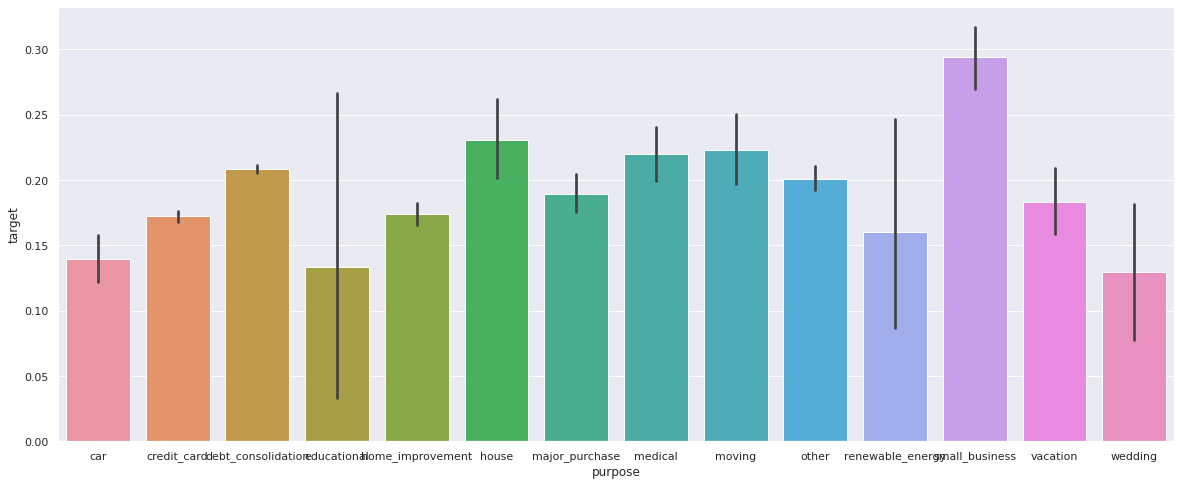

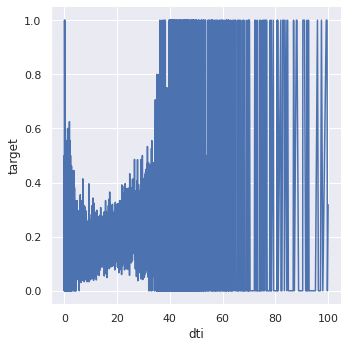

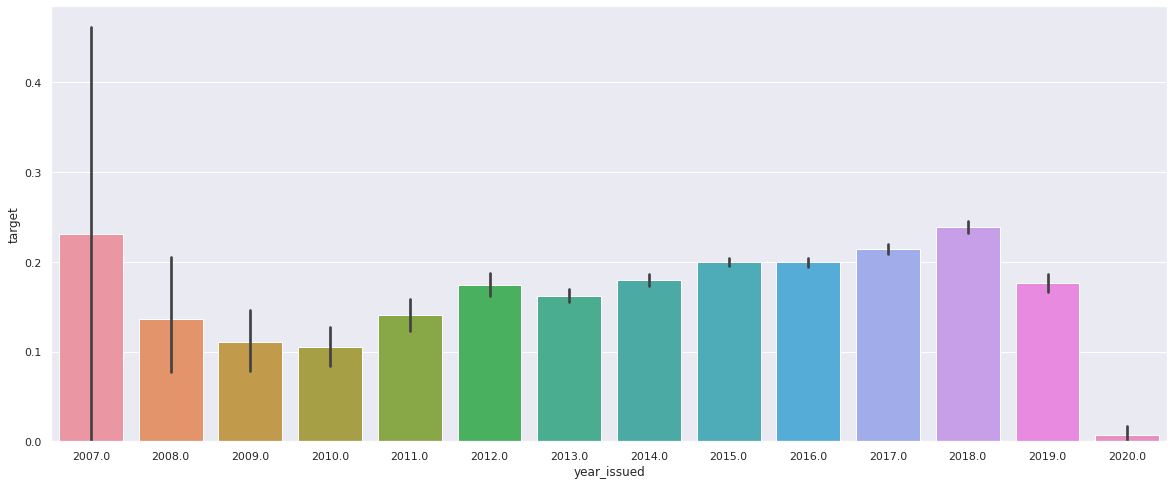

In [256]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

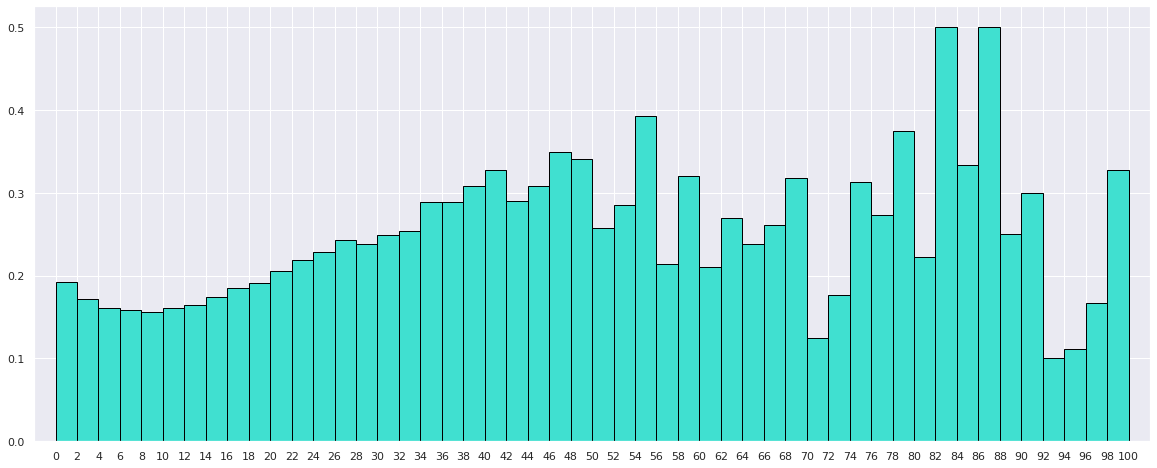

In [261]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### Train-test split, missing values

In [185]:
display(df.count())

loan_amnt                         127078
funded_amnt                       127078
funded_amnt_inv                   127078
term                              127078
int_rate                          127078
installment                       127078
purpose                           127078
title                             125654
initial_list_status               127078
application_type                  127078
grade                             127078
sub_grade                         127078
fico_range_high                   127078
emp_title                         118193
emp_length                        119133
home_ownership                    127078
annual_inc                        127078
zip_code                          127078
addr_state                        127078
dti                               127011
verification_status               127078
mo_sin_rcnt_tl                    127078
mths_since_last_delinq            127078
mths_since_last_major_derog       127078
mths_since_last_

In [186]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

df['emp_length'] = df['emp_length'].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(114371, 72)

(12707, 72)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt
0,10000.0,10000.0,10000.0,60.0,11.99,222.399994,debt_consolidation,Debt consolidation,f,Individual,B,B3,694.0,MISSING,0.0,MORTGAGE,54000.0,334,FL,22.059999,Verified,15.0,46.0,46.0,1200.0,46.0,46.0,0.0,0.0,0.0,0.0,11.0,1.0,6.0,22.0,22341.0,245752.0,17550.0,50.9,0.0,0.0,0.0,0.0,0.0,20925.0,26572.0,0.0,25.0,81.0,NaN,NaN,0.0,0.0,0.0,3.0,2014,1,2014,44.753828,0.0,0.0,0.185185,0.049422,0,0.325000,0.413722,4.550963,0.387500,0,0.500000,0,0
1,10000.0,10000.0,9975.0,60.0,11.80,221.440002,debt_consolidation,Debt consolidation,f,Individual,B,B4,714.0,Valet,0.0,MORTGAGE,30000.0,787,TX,23.559999,Source Verified,0.0,36.0,1200.0,1200.0,39.0,36.0,2.0,1.0,0.0,1.0,7.0,3.0,1.0,18.0,6057.0,42398.0,11293.0,45.2,0.0,0.0,0.0,0.0,0.0,18253.0,0.0,0.0,0.0,87.5,2.0,0.0,0.0,0.0,0.0,0.0,2018,11,2018,9.418400,0.0,0.0,0.333333,0.088576,0,0.376433,0.201900,1.413267,0.608433,0,0.388889,0,0
2,20400.0,20400.0,20400.0,36.0,19.22,750.059998,debt_consolidation,Debt Consolidation,f,Individual,D,D5,664.0,XenoPsi,0.0,RENT,105000.0,180,PA,3.370000,Verified,120.0,47.0,1200.0,1200.0,1200.0,47.0,0.0,1.0,0.0,0.0,9.0,5.0,0.0,32.0,NaN,NaN,10783.0,66.6,0.0,0.0,0.0,0.0,0.0,10783.0,NaN,0.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,6,2012,17.254290,0.0,0.0,0.194286,0.085721,0,0.102695,NaN,NaN,0.102695,0,0.281250,0,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt
0,7250.0,7250.0,7250.0,36.0,16.99,258.450012,debt_consolidation,Debt consolidation,w,Individual,D,D3,699.0,CTERING,5.0,RENT,45000.0,72,NJ,15.570000,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,5.0,3.0,0.0,5.0,4316.0,21578.0,3393.0,45.2,0.0,0.0,0.0,0.0,0.0,21578.0,0.0,0.0,66.699997,100.0,NaN,NaN,0.0,0.0,0.0,0.0,2014,8,2014,6.332779,0.0,0.0,0.161111,0.068920,0,0.075400,0.095911,0.479511,0.479511,0,1.000000,0,0
1,14075.0,14075.0,14075.0,36.0,15.31,490.059998,debt_consolidation,Debt consolidation,f,Individual,C,C2,684.0,METRO AUTO PARTS,2.0,RENT,40000.0,919,CA,9.120000,Not Verified,7.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,10.0,5.0,0.0,17.0,1105.0,11045.0,11045.0,47.8,0.0,0.0,0.0,0.0,0.0,11045.0,0.0,0.0,75.000000,100.0,NaN,NaN,0.0,0.0,0.0,0.0,2013,1,2013,7.167841,0.0,0.0,0.351875,0.147018,0,0.276125,0.027625,0.276125,0.276125,0,0.588235,0,0
2,17000.0,17000.0,17000.0,60.0,11.99,378.070007,medical,Medical expenses,w,Individual,B,B5,749.0,Associate Director,10.0,MORTGAGE,92000.0,318,GA,19.969999,Not Verified,8.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,0.0,1.0,1.0,15.0,7.0,5.0,38.0,26353.0,368947.0,13695.0,31.3,0.0,0.0,0.0,0.0,0.0,61042.0,0.0,0.0,16.700001,100.0,1.0,2.0,0.0,0.0,0.0,0.0,2017,9,2017,14.253544,0.0,0.0,0.184783,0.049313,0,0.148859,0.286446,4.010293,0.663500,0,0.394737,0,0


loan_amnt                         114371
funded_amnt                       114371
funded_amnt_inv                   114371
term                              114371
int_rate                          114371
installment                       114371
purpose                           114371
title                             114371
initial_list_status               114371
application_type                  114371
grade                             114371
sub_grade                         114371
fico_range_high                   114371
emp_title                         114371
emp_length                        114371
home_ownership                    114371
annual_inc                        114371
zip_code                          114371
addr_state                        114371
dti                               114371
verification_status               114371
mo_sin_rcnt_tl                    114371
mths_since_last_delinq            114371
mths_since_last_major_derog       114371
mths_since_last_

loan_amnt                         12707
funded_amnt                       12707
funded_amnt_inv                   12707
term                              12707
int_rate                          12707
installment                       12707
purpose                           12707
title                             12707
initial_list_status               12707
application_type                  12707
grade                             12707
sub_grade                         12707
fico_range_high                   12707
emp_title                         12707
emp_length                        12707
home_ownership                    12707
annual_inc                        12707
zip_code                          12707
addr_state                        12707
dti                               12707
verification_status               12707
mo_sin_rcnt_tl                    12707
mths_since_last_delinq            12707
mths_since_last_major_derog       12707
mths_since_last_record            12707


### Categorical features encoding

In [187]:
# TE for categorical features

test00 = test.copy()
time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

43.904330015182495

3.573944091796875

(114371, 72)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,10000.0,10000.0,10000.0,60.0,11.99,222.399994,f,Individual,694.0,0.0,54000.0,22.059999,Verified,15.0,46.0,46.0,1200.0,46.0,46.0,0.0,0.0,0.0,0.0,11.0,1.0,6.0,22.0,22341.0,245752.0,17550.0,50.9,0.0,0.0,0.0,0.0,0.0,20925.0,26572.0,0.0,25.000000,81.000000,NaN,NaN,0.0,0.0,0.0,3.0,2014,1,2014,44.753828,0.000000,0.0,0.185185,0.049422,0,0.325000,0.413722,4.550963,0.387500,0,0.500000,0,0,0.134313,0.129515,0.269794,0.168659,0.208690,0.213241,0.207378,0.210366
1,10000.0,10000.0,9975.0,60.0,11.80,221.440002,f,Individual,714.0,0.0,30000.0,23.559999,Source Verified,0.0,36.0,1200.0,1200.0,39.0,36.0,2.0,1.0,0.0,1.0,7.0,3.0,1.0,18.0,6057.0,42398.0,11293.0,45.2,0.0,0.0,0.0,0.0,0.0,18253.0,0.0,0.0,0.000000,87.500000,2.0,0.0,0.0,0.0,0.0,0.0,2018,11,2018,9.418400,0.000000,0.0,0.333333,0.088576,0,0.376433,0.201900,1.413267,0.608433,0,0.388889,0,0,0.134313,0.157515,0.330850,0.168659,0.208690,0.213241,0.150377,0.199740
2,20400.0,20400.0,20400.0,36.0,19.22,750.059998,f,Individual,664.0,0.0,105000.0,3.370000,Verified,120.0,47.0,1200.0,1200.0,1200.0,47.0,0.0,1.0,0.0,0.0,9.0,5.0,0.0,32.0,NaN,NaN,10783.0,66.6,0.0,0.0,0.0,0.0,0.0,10783.0,NaN,0.0,75.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,6,2012,17.254290,0.000000,0.0,0.194286,0.085721,0,0.102695,NaN,NaN,0.102695,0,0.281250,0,0,0.302495,0.326118,0.197020,0.229251,0.208690,0.133839,0.243564,0.204736
3,1400.0,1400.0,1400.0,36.0,23.70,54.709999,f,Individual,669.0,5.0,45000.0,11.390000,Not Verified,1.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,10.0,5.0,0.0,20.0,891.0,8911.0,8911.0,45.9,0.0,0.0,0.0,0.0,0.0,8911.0,0.0,0.0,60.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013,12,2013,4.829668,0.000000,1.0,0.031111,0.014589,0,0.198022,0.019800,0.198022,0.198022,0,0.500000,0,0,0.448716,0.431766,0.155319,0.229251,0.188150,0.109456,0.216200,0.194983
4,10000.0,10000.0,10000.0,36.0,15.99,351.529999,w,Individual,679.0,5.0,35000.0,16.799999,Source Verified,7.0,5.0,5.0,61.0,1200.0,1200.0,3.0,2.0,0.0,0.0,13.0,7.0,1.0,51.0,2172.0,21724.0,3603.0,37.1,1.0,0.0,0.0,1.0,1.0,21724.0,0.0,0.0,33.299999,97.400002,NaN,NaN,1.0,0.0,0.0,1.0,2015,1,2015,19.915536,0.050212,0.0,0.285714,0.120525,0,0.102943,0.062057,0.620686,0.620686,0,0.254902,0,1,0.302495,0.293854,0.197020,0.229251,0.135942,0.142264,0.223300,0.212594


loan_amnt                         114371
funded_amnt                       114371
funded_amnt_inv                   114371
term                              114371
int_rate                          114371
installment                       114371
initial_list_status               114371
application_type                  114371
fico_range_high                   114371
emp_length                        114371
annual_inc                        114371
dti                               114371
verification_status               114371
mo_sin_rcnt_tl                    114371
mths_since_last_delinq            114371
mths_since_last_major_derog       114371
mths_since_last_record            114371
mths_since_recent_bc_dlq          114371
mths_since_recent_revol_delinq    114371
num_tl_op_past_12m                114371
inq_last_6mths                    114371
inq_fi                            114371
inq_last_12m                      114371
open_acc                          114371
acc_open_past_24

In [188]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,7250.0,7250.0,7250.0,36.0,16.99,258.450012,w,Individual,699.0,5.0,45000.0,15.570000,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,5.0,3.0,0.0,5.0,4316.0,21578.0,3393.0,45.2,0.0,0.0,0.0,0.0,0.0,21578.0,0.0,0.0,66.699997,100.0,NaN,NaN,0.0,0.0,0.0,0.0,2014,8,2014,6.332779,0.0,0.161111,0.068920,0,0.075400,0.095911,0.479511,0.479511,0,1.000000,0,0,0.301324,0.296983,0.196239,0.230086,0.208401,0.212734,0.255931,0.214340
1,14075.0,14075.0,14075.0,36.0,15.31,490.059998,f,Individual,684.0,2.0,40000.0,9.120000,Not Verified,7.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,10.0,5.0,0.0,17.0,1105.0,11045.0,11045.0,47.8,0.0,0.0,0.0,0.0,0.0,11045.0,0.0,0.0,75.000000,100.0,NaN,NaN,0.0,0.0,0.0,0.0,2013,1,2013,7.167841,0.0,0.351875,0.147018,0,0.276125,0.027625,0.276125,0.276125,0,0.588235,0,0,0.225586,0.203678,0.196239,0.230086,0.208401,0.212734,0.245048,0.195104
2,17000.0,17000.0,17000.0,60.0,11.99,378.070007,w,Individual,749.0,10.0,92000.0,19.969999,Not Verified,8.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,0.0,1.0,1.0,15.0,7.0,5.0,38.0,26353.0,368947.0,13695.0,31.3,0.0,0.0,0.0,0.0,0.0,61042.0,0.0,0.0,16.700001,100.0,1.0,2.0,0.0,0.0,0.0,0.0,2017,9,2017,14.253544,0.0,0.184783,0.049313,0,0.148859,0.286446,4.010293,0.663500,0,0.394737,0,0,0.135398,0.168092,0.107384,0.167300,0.199683,0.207442,0.136206,0.180097
3,15000.0,15000.0,15000.0,36.0,18.75,547.950012,f,Individual,669.0,2.0,99600.0,10.040000,Not Verified,7.0,30.0,1200.0,1200.0,30.0,30.0,1.0,1.0,0.0,0.0,8.0,7.0,2.0,24.0,50413.0,403302.0,26054.0,79.9,0.0,0.0,0.0,0.0,0.0,26054.0,0.0,0.0,100.000000,100.0,NaN,NaN,0.0,0.0,0.0,0.0,2012,10,2012,11.833234,0.0,0.150602,0.066018,0,0.261586,0.506155,4.049217,0.261586,0,0.333333,0,0,0.301324,0.296983,0.196239,0.167300,0.166535,0.142979,0.196049,0.214340
4,3600.0,3600.0,3600.0,36.0,10.42,116.879997,w,Individual,729.0,8.0,44400.0,14.490000,Not Verified,2.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,2.0,2.0,4.0,7.0,7.0,0.0,12.0,4672.0,32706.0,1270.0,10.0,0.0,0.0,0.0,0.0,0.0,32706.0,0.0,0.0,0.000000,100.0,3.0,2.0,0.0,0.0,0.0,0.0,2017,7,2017,5.412842,0.0,0.081081,0.031589,0,0.028604,0.105225,0.736622,0.736622,0,0.583333,0,0,0.135398,0.128969,0.191655,0.230086,0.208401,0.212734,0.224669,0.212516


Number of features before transaformation:  (114371, 71)
time to do feature proprocessing:  4.03511381149292
Number of features after transaformation:  (114371, 75)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_f,cat__initial_list_status_w,cat__application_type_Individual,cat__application_type_Joint App,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__fico_range_high,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__mo_sin_rcnt_tl,remainder__mths_since_last_delinq,remainder__mths_since_last_major_derog,remainder__mths_since_last_record,remainder__mths_since_recent_bc_dlq,remainder__mths_since_recent_revol_delinq,remainder__num_tl_op_past_12m,remainder__inq_last_6mths,remainder__inq_fi,remainder__inq_last_12m,remainder__open_acc,remainder__acc_open_past_24mths,remainder__mort_acc,remainder__total_acc,remainder__avg_cur_bal,remainder__tot_cur_bal,remainder__revol_bal,remainder__revol_util,remainder__delinq_2yrs,remainder__acc_now_delinq,remainder__delinq_amnt,remainder__pub_rec,remainder__pub_rec_bankruptcies,remainder__total_bal_ex_mort,remainder__tot_coll_amt,remainder__tax_liens,remainder__percent_bc_gt_75,remainder__pct_tl_nvr_dlq,remainder__open_rv_12m,remainder__open_il_12m,remainder__num_tl_90g_dpd_24m,remainder__num_tl_30dpd,remainder__num_tl_120dpd_2m,remainder__num_accts_ever_120_pd,remainder__year_issued,remainder__month_issued,remainder__year_earliest,remainder__years_borrowing,remainder__pub_rec_pa,remainder__lti,remainder__iti,remainder__joint,remainder__revol_balance_income,remainder__avg_cur_bal_inc,remainder__tot_cur_bal_inc,remainder__total_bal_ex_mort_inc,remainder__low_fico,remainder__open_cl_ratio,remainder__hobo,remainder__was_bankrupt,remainder__grade_encoded,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__home_ownership_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded
0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,10000.0,10000.0,10000.0,60.0,11.99,222.399994,694.0,0.0,54000.0,22.059999,15.0,46.0,46.0,1200.0,46.0,46.0,0.0,0.0,0.0,0.0,11.0,1.0,6.0,22.0,22341.0,245752.0,17550.0,50.9,0.0,0.0,0.0,0.0,0.0,20925.0,26572.0,0.0,25.000000,81.000000,NaN,NaN,0.0,0.0,0.0,3.0,2014.0,1.0,2014.0,44.753828,0.000000,0.185185,0.049422,0.0,0.325000,0.413722,4.550963,0.387500,0.0,0.500000,0.0,0.0,0.134313,0.129515,0.269794,0.168659,0.208690,0.213241,0.207378,0.210366
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,10000.0,10000.0,9975.0,60.0,11.80,221.440002,714.0,0.0,30000.0,23.559999,0.0,36.0,1200.0,1200.0,39.0,36.0,2.0,1.0,0.0,1.0,7.0,3.0,1.0,18.0,6057.0,42398.0,11293.0,45.2,0.0,0.0,0.0,0.0,0.0,18253.0,0.0,0.0,0.000000,87.500000,2.0,0.0,0.0,0.0,0.0,0.0,2018.0,11.0,2018.0,9.418400,0.000000,0.333333,0.088576,0.0,0.376433,0.201900,1.413267,0.608433,0.0,0.388889,0.0,0.0,0.134313,0.157515,0.330850,0.168659,0.208690,0.213241,0.150377,0.199740
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,20400.0,20400.0,20400.0,36.0,19.22,750.059998,664.0,0.0,105000.0,3.370000,120.0,47.0,1200.0,1200.0,1200.0,47.0,0.0,1.0,0.0,0.0,9.0,5.0,0.0,32.0,NaN,NaN,10783.0,66.6,0.0,0.0,0.0,0.0,0.0,10783.0,NaN,0.0,75.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,6.0,2012.0,17.254290,0.000000,0.194286,0.085721,0.0,0.102695,NaN,NaN,0.102695,0.0,0.281250,0.0,0.0,0.302495,0.326118,0.197020,0.229251,0.208690,0.133839,0.243564,0.204736
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1400.0,1400.0,1400.0,36.0,23.70,54.709999,669.0,5.0,45000.0,11.390000,1.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,10.0,5.0,0.0,20.0,891.0,8911.0,8911.0,45.9,0.0,0.0,0.0,0.0,0.0,8911.0,0.0,0.0,60.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013.0,12.0,2013.0,4.829668,0.000000,0.031111,0.014589,0.0,0.198022,0.019800,0.198022,0.198022,0.0,0.500000,0.0,0.0,0.448716,0.431766,0.155319,0.229251,0.188150,0.109456,0.216200,0.194983
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,10000.0,10000.0,10000.0,36.0,15.99,351.529999,679.0,5.0,35000.0,16.799999,7.0,5.0,5.0,61.0,1200.0,1200.0,3.0,2.0,0.0,0.0,13.0,7.0,1.0,51.0,2172.0,21724.0,3603.0,37.1,1.0,

### Modeling

In [189]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

'Train Accuracy: '

0.8405452431123275

'F1 score: '

0.369158393579854

'ROCAUC: '

0.6127328989516114

'PRAUC: '

0.6268154525093987

'R20P: '

0.8515565679574791

'Test Accuracy: '

0.7991658141182025

'F1 score: '

0.18518518518518517

'ROCAUC: '

0.5423611946196566

'PRAUC: '

0.3680830514357104

'R20P: '

0.44669603524229073

3.250852108001709

In [190]:
### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=1):

    cv_regularizer=0.06
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.4),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

[I 2022-08-12 21:08:04,206] A new study created in memory with name: no-name-8d879d7a-c814-4ca5-8bd0-e26b7dd24d1d
[I 2022-08-12 21:08:11,736] Trial 0 finished with value: 0.5470329544811615 and parameters: {'n_estimators': 822, 'max_depth': 2, 'learning_rate': 0.39323625825436664, 'colsample_bytree': 0.8953777349499195, 'subsample': 0.7561885517462602, 'alpha': 0.20165133338872956, 'lambda': 30.701941716980542, 'gamma': 2.959539733849261e-10, 'min_child_weight': 0.8198808281894634}. Best is trial 0 with value: 0.5470329544811615.
[I 2022-08-12 21:08:20,361] Trial 1 finished with value: 0.5404885822365614 and parameters: {'n_estimators': 785, 'max_depth': 3, 'learning_rate': 0.05618459303195804, 'colsample_bytree': 0.7695345373348911, 'subsample': 0.7051197808222464, 'alpha': 0.3527375155817586, 'lambda': 45.292248385267314, 'gamma': 3.7475469006347196e-05, 'min_child_weight': 5.241671592470653}. Best is trial 0 with value: 0.5470329544811615.
[I 2022-08-12 21:08:33,805] Trial 2 finishe

Total time for hypermarameter optimization  498.4885058403015
        n_estimators : 878
           max_depth : 2
       learning_rate : 0.32348925005431006
    colsample_bytree : 0.3777237923744589
           subsample : 0.8157237538205989
               alpha : 1.275758009657802
              lambda : 0.10100318289193129
               gamma : 1.176556641458091e-08
    min_child_weight : 0.24490530773666933
best objective value : 0.5504405389751901


'Train Accuracy: '

0.8179608467181366

'F1 score: '

0.24158531254553403

'ROCAUC: '

0.5646697954371857

'PRAUC: '

0.4710214932748096

'R20P: '

0.6166323024054983

'Test Accuracy: '

0.8016841111198552

'F1 score: '

0.19334186939820744

'ROCAUC: '

0.545702816726593

'PRAUC: '

0.3804283898720101

'R20P: '

0.4824976348155156

505.79789876937866

In [191]:
results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
fi = fi.sort_values('FI', ascending = False)

display(fi[:30])

,col,FI
10,remainder__term,0.003699
51,remainder__year_issued,0.002581
59,remainder__revol_balance_income,0.002314
60,remainder__avg_cur_bal_inc,0.002188
31,remainder__avg_cur_bal,0.002062
33,remainder__revol_bal,0.001999
70,remainder__home_ownership_encoded,0.001857
29,remainder__mort_acc,0.001700
28,remainder__acc_open_past_24mths,0.001700
61,remainder__tot_cur_bal_inc,0.001558


,col_name,feature_importance_vals
10,remainder__term,0.233642
28,remainder__acc_open_past_24mths,0.142730
68,remainder__sub_grade_encoded,0.135072
11,remainder__int_rate,0.131595
16,remainder__dti,0.120586
67,remainder__grade_encoded,0.109844
13,remainder__fico_range_high,0.109535
70,remainder__home_ownership_encoded,0.101630
51,remainder__year_issued,0.097542
69,remainder__emp_title_encoded,0.094413


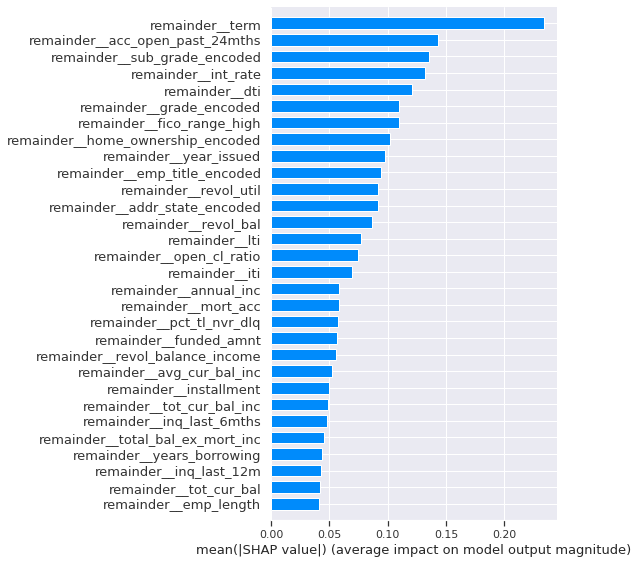

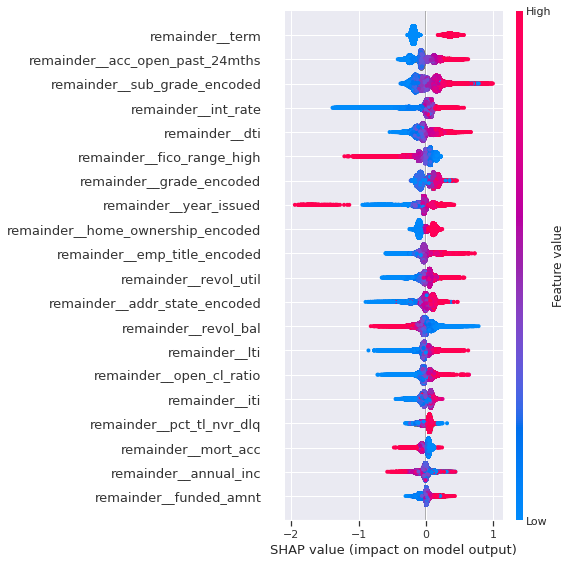

In [192]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
display(feature_importance[:30])

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)

shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [193]:
# error analysis
y_pred = optuna_xgb.predict_proba(X_test)[:, 1]
error_df = test0.copy()
error_df['truth'] = y_test
error_df['pred'] = y_pred
error_df['error'] = error_df.pred - error_df.truth
error_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,truth,pred,error
0,7250.0,7250.0,7250.0,36.0,16.99,258.450012,w,Individual,699.0,5.0,45000.0,15.570000,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,5.0,3.0,0.0,5.0,4316.0,21578.0,3393.0,45.2,0.0,0.0,0.0,0.0,0.0,21578.0,0.0,0.0,66.699997,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2014,8,2014,6.332779,0.0,0.0,0.161111,0.068920,0,0.075400,0.095911,0.479511,0.479511,0,1.000000,0,0,0.301324,0.296983,0.196239,0.230086,0.208401,0.212734,0.255931,0.214340,0.0,0.153964,0.153964
1,14075.0,14075.0,14075.0,36.0,15.31,490.059998,f,Individual,684.0,2.0,40000.0,9.120000,Not Verified,7.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,10.0,5.0,0.0,17.0,1105.0,11045.0,11045.0,47.8,0.0,0.0,0.0,0.0,0.0,11045.0,0.0,0.0,75.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013,1,2013,7.167841,0.0,0.0,0.351875,0.147018,0,0.276125,0.027625,0.276125,0.276125,0,0.588235,0,0,0.225586,0.203678,0.196239,0.230086,0.208401,0.212734,0.245048,0.195104,0.0,0.155169,0.155169
2,17000.0,17000.0,17000.0,60.0,11.99,378.070007,w,Individual,749.0,10.0,92000.0,19.969999,Not Verified,8.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,0.0,1.0,1.0,15.0,7.0,5.0,38.0,26353.0,368947.0,13695.0,31.3,0.0,0.0,0.0,0.0,0.0,61042.0,0.0,0.0,16.700001,100.000000,1.0,2.0,0.0,0.0,0.0,0.0,2017,9,2017,14.253544,0.0,0.0,0.184783,0.049313,0,0.148859,0.286446,4.010293,0.663500,0,0.394737,0,0,0.135398,0.168092,0.107384,0.167300,0.199683,0.207442,0.136206,0.180097,0.0,0.066902,0.066902
3,15000.0,15000.0,15000.0,36.0,18.75,547.950012,f,Individual,669.0,2.0,99600.0,10.040000,Not Verified,7.0,30.0,1200.0,1200.0,30.0,30.0,1.0,1.0,0.0,0.0,8.0,7.0,2.0,24.0,50413.0,403302.0,26054.0,79.9,0.0,0.0,0.0,0.0,0.0,26054.0,0.0,0.0,100.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2012,10,2012,11.833234,0.0,0.0,0.150602,0.066018,0,0.261586,0.506155,4.049217,0.261586,0,0.333333,0,0,0.301324,0.296983,0.196239,0.167300,0.166535,0.142979,0.196049,0.214340,0.0,0.123260,0.123260
4,3600.0,3600.0,3600.0,36.0,10.42,116.879997,w,Individual,729.0,8.0,44400.0,14.490000,Not Verified,2.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,2.0,2.0,4.0,7.0,7.0,0.0,12.0,4672.0,32706.0,1270.0,10.0,0.0,0.0,0.0,0.0,0.0,32706.0,0.0,0.0,0.000000,100.000000,3.0,2.0,0.0,0.0,0.0,0.0,2017,7,2017,5.412842,0.0,1.0,0.081081,0.031589,0,0.028604,0.105225,0.736622,0.736622,0,0.583333,0,0,0.135398,0.128969,0.191655,0.230086,0.208401,0.212734,0.224669,0.212516,1.0,0.132673,-0.867327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12702,16000.0,16000.0,16000.0,60.0,15.59,385.619995,w,Individual,679.0,8.0,95000.0,21.410000,Source Verified,5.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,11.0,6.0,0.0,16.0,8169.0,89854.0,15473.0,69.7,0.0,0.0,0.0,0.0,0.0,89854.0,0.0,0.0,80.000000,100.0

In [206]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error<-0.97])

,truth,pred
count,12707.000000,12707.000000
mean,0.200283,0.199508
std,0.400228,0.144559
min,0.000000,0.001710
25%,0.000000,0.089082
50%,0.000000,0.164559
75%,0.000000,0.274686
max,1.000000,0.909164


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,low_fico,open_cl_ratio,hobo,was_bankrupt,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,truth,pred,error
35,24000.0,24000.0,24000.000000,36.0,7.62,747.880005,f,Individual,799.0,10.0,98000.0,16.620001,Not Verified,9.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,2.0,0.0,0.0,14.0,2.0,5.0,39.0,2970.0,35642.0,13877.0,17.5,0.0,0.0,0.0,0.0,0.0,35642.0,0.0,0.0,0.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2014,4,2014,19.001075,0.000000,1.0,0.244898,0.091577,0,0.141602,0.030306,0.363694,0.363694,0,0.358974,0,0,0.066727,0.063403,0.177113,0.230086,0.208401,0.212734,0.215690,0.195104,1.0,0.027165,-0.972835
96,35000.0,35000.0,34725.000000,36.0,6.08,1066.040039,f,Individual,744.0,5.0,120000.0,8.220000,Source Verified,13.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,11.0,2.0,2.0,16.0,20677.0,227448.0,26327.0,32.8,0.0,0.0,0.0,0.0,0.0,32600.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2017,11,2017,8.336927,0.000000,1.0,0.291667,0.106604,0,0.219392,0.172308,1.895400,0.271667,0,0.687500,0,0,0.066727,0.048918,0.143683,0.167300,0.169723,0.173934,0.231213,0.217278,1.0,0.024133,-0.975867
251,15000.0,15000.0,15000.000000,36.0,6.72,461.239990,w,Joint App,804.0,0.0,69923.0,5.970000,Source Verified,27.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,8.0,0.0,5.0,18.0,14608.0,116865.0,13317.0,25.7,0.0,0.0,0.0,0.0,0.0,13317.0,0.0,0.0,25.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2017,11,2017,36.337502,0.000000,1.0,0.214522,0.079157,1,0.190452,0.208916,1.671338,0.190452,0,0.444444,0,0,0.066727,0.063403,0.196239,0.167300,0.208401,0.212734,0.187806,0.144460,1.0,0.022988,-0.977012
1418,4750.0,4750.0,4750.000000,36.0,14.16,162.720001,w,Individual,664.0,10.0,55000.0,6.850000,Not Verified,4.0,41.0,46.0,1200.0,49.0,46.0,4.0,1.0,0.0,0.0,6.0,6.0,2.0,30.0,17943.0,107658.0,1669.0,6.3,0.0,0.0,0.0,0.0,0.0,1669.0,0.0,0.0,0.000000,77.800003,NaN,NaN,0.0,0.0,0.0,8.0,2014,3,2014,26.916364,0.000000,1.0,0.086364,0.035503,0,0.030345,0.326236,1.957418,0.030345,0,0.200000,0,0,0.225586,0.203678,0.209432,0.167300,0.166535,0.171676,0.181888,0.200018,1.0,0.024208,-0.975792
1618,15000.0,15000.0,15000.000000,36.0,5.32,451.730011,w,Individual,724.0,10.0,53000.0,9.620000,Source Verified,4.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,17.0,7952.0,15904.0,15904.0,80.0,0.0,0.0,0.0,0.0,0.0,15904.0,0.0,0.0,50.000000,100.000000,1.0,0.0,0.0,0.0,NaN,0.0,2016,11,2016,31.168333,0.000000,1.0,0.283019,0.102278,0,0.300075,0.150038,0.300075,0.300075,0,0.117647,0,0,0.066727,0.033751,0.196239,0.204279,0.169723,0.173934,0.157453,0.232579,1.0,0.029631,-0.970369
2923,35000.0,35000.0,35000.000000,36.0,6.99,1080.540039,w,Individual,714.0,10.0,380000.0,18.379999,Verified,9.0,41.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,12.0,2.0,2.0,16.0,39477.0,434244.0,98355.0,86.2,0.0,0.0,0.0,0.0,0.0,189389.0,0.0,0.0,100.000000,87.500000,0.0,1.0,0.0,0.0,0.0,1.0,2016,12,2016,29.169661,0.000000,1.0,0.092105,0.034122,0,0.258829,0.103887,1.142747,0.498392,0,0.750000,0,0,0.066727,0.048918,0.182840,0.167300,0.169723,0.173934,0.168349,0.166757,1.0,0.015538,-0.984462
3

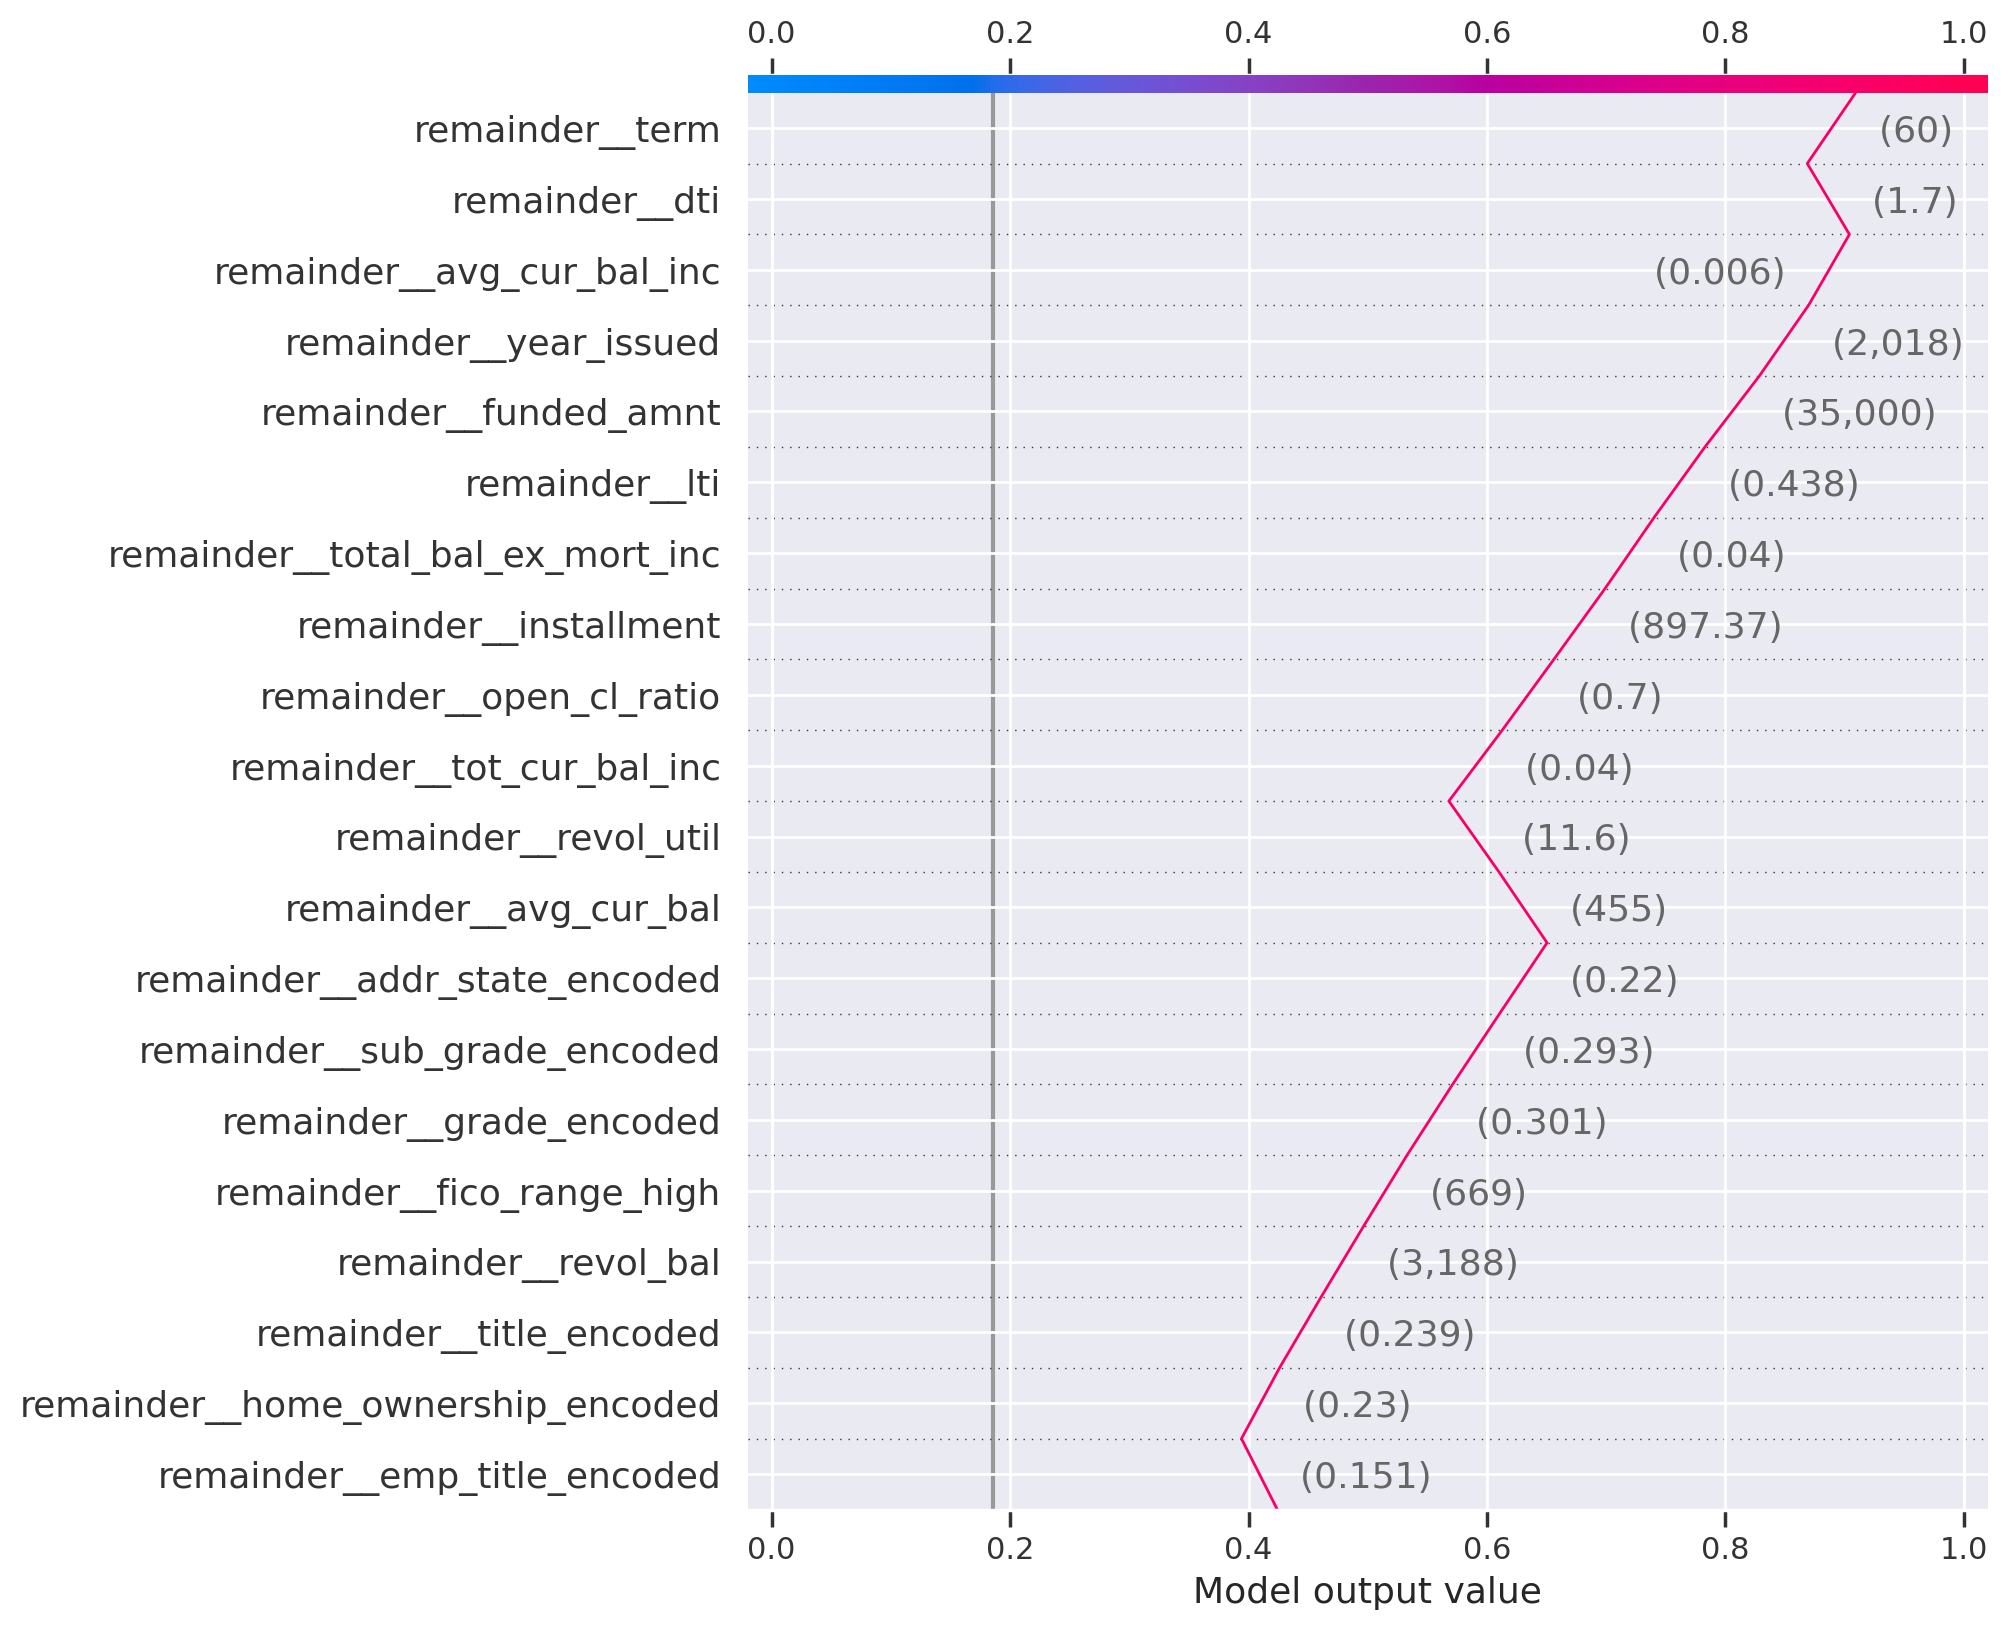

In [199]:
indx = 9506
fig = plt.subplots(figsize=(6,6),dpi=200)
ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

In [202]:
shap.initjs()
shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [197]:
error_df[['pred','truth']].describe()

,pred,truth
count,12707.000000,12707.000000
mean,0.199508,0.200283
std,0.144559,0.400228
min,0.001710,0.000000
25%,0.089082,0.000000
50%,0.164559,0.000000
75%,0.274686,0.000000
max,0.909164,1.000000


In [198]:
time.time()-time0

612.6765687465668